# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). The emails used to train this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). 

In [ ]:
from bs4 import BeautifulSoup
import email
import joblib
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import string

## 1 Preprocessing

In [34]:
def process_email(txt):
    """
    Takes an email message and cleans it up for use with CountVectorizer().
    """
    if (type(txt) == bytes):
        msg_email = email.message_from_bytes(txt)
    else:
        msg_email = email.message_from_string(txt)
        
    # Only use the message body
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = re.sub('\n', ' ', msg)
    msg = re.sub('\t', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = re.sub('[0-9]+', 'number', msg)
    msg = re.sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = re.sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = re.sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    msg = msg.translate(table)
    return msg

stemmer = PorterStemmer()
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()

def stemmed_words(doc):
    doc = process_email(doc)
    return (stemmer.stem(w) for w in analyzer(doc))

### 1.1 Load the text files
`load_files` is a nice function for loading large amounts of data. I have the spam emails in `./data/spam` and the ham emails in `./data/ham`. `load_files` automatically classifies the documents based on which folder they are in.

In [2]:
from sklearn.datasets import load_files

In [3]:
emails = load_files('data/')

In [4]:
emails.target_names

['ham', 'spam']

In [5]:
emails.target

array([0, 1, 0, ..., 0, 0, 0])

### 1.2 Split data into train and test sets
`train_test_split` shuffles the data by default and splits the data into training and test sets.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(emails.data, emails.target)

Here's one example of an email before and after it is processed (before stemming).

In [9]:
X_train[0]

b'From ilug-admin@linux.ie  Fri Sep  6 11:40:08 2002\nReturn-Path: <ilug-admin@linux.ie>\nDelivered-To: zzzz@localhost.example.com\nReceived: from localhost (jalapeno [127.0.0.1])\n\tby example.com (Postfix) with ESMTP id AE33716F56\n\tfor <zzzz@localhost>; Fri,  6 Sep 2002 11:38:08 +0100 (IST)\nReceived: from jalapeno [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Fri, 06 Sep 2002 11:38:08 +0100 (IST)\nReceived: from webnote.net (mail.webnote.net [193.120.211.219]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g86921C27133 for\n    <zzzz-ilug@example.com>; Fri, 6 Sep 2002 10:02:02 +0100\nReceived: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by\n    webnote.net (8.9.3/8.9.3) with ESMTP id DAA19755 for <zzzz-ilug@example.com>;\n    Fri, 6 Sep 2002 03:14:46 +0100\nReceived: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org\n    (8.9.3/8.9.3) with ESMTP id DAA21093; Fri, 6 Sep 2002 03:13:57 +0100\nX-Authent

In [13]:
process_email(X_train[0])

'quoting waider emailaddr   niall sheridan wrote   a power cycle will do it   other than that its chipset specific    sure tried powercycling an internal modem recently     waider this is rick moen bait  thanks  it was delicious      cheers               that article and its poster have been cancelled  rick moen                    david b odonnel sysadmin for america online emailaddr    irish linux users group emailaddr httpaddr for unsubscription information list maintainer emailaddr  '

## 2 Support Vector Machine

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

### 2.1 Grid search and cross-validation on train set

We convert the emails into feature vectors which tell whether or not a word occurs in the email. This is a grid search that tries different values of `C` for the SVC. We setup `CountVectorizer` to use stemming and process via our custom process function.

In [47]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=2000, 
                             decode_error='ignore',
                             binary=True,
                             analyzer=stemmed_words)),
    ('svc', SVC(kernel='linear')),
])

A quick check to see if our CountVectorizer is working like we think.

In [48]:
vect = CountVectorizer(decode_error='ignore', binary=True, analyzer=stemmed_words)
vect.fit_transform([X_train[0]])
vect.get_feature_names()

['america',
 'an',
 'and',
 'articl',
 'bait',
 'been',
 'cancel',
 'cheer',
 'chipset',
 'cycl',
 'david',
 'delici',
 'do',
 'emailaddr',
 'for',
 'group',
 'have',
 'httpaddr',
 'inform',
 'intern',
 'irish',
 'is',
 'it',
 'linux',
 'list',
 'maintain',
 'modem',
 'moen',
 'niall',
 'odonnel',
 'onlin',
 'other',
 'poster',
 'power',
 'powercycl',
 'quot',
 'recent',
 'rick',
 'sheridan',
 'specif',
 'sure',
 'sysadmin',
 'than',
 'thank',
 'that',
 'thi',
 'tri',
 'unsubscript',
 'user',
 'wa',
 'waider',
 'will',
 'wrote']

In [49]:
tuned_parameters = [{'svc__C': np.logspace(-2,2,5)}]
clf = GridSearchCV(pipeline, param_grid=tuned_parameters, 
                   scoring="f1", return_train_score=True,
                   verbose=10, n_jobs=3, cv=5)
clf.fit(X_train, y_train)
joblib.dump(clf, 'clf.gz')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] svc__C=0.01 .....................................................
[CV] ............ svc__C=0.01, score=0.9023136246786633, total= 1.4min
[CV] svc__C=0.01 .....................................................
[CV] ............. svc__C=0.01, score=0.858034321372855, total= 1.3min
[CV] svc__C=0.01 .....................................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.5min


[CV] ............ svc__C=0.01, score=0.8593508500772797, total= 1.4min
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.8682170542635658, total= 1.4min
[CV] svc__C=0.1 ......................................................
[CV] ............ svc__C=0.01, score=0.9010416666666666, total= 1.5min
[CV] svc__C=0.1 ......................................................
[CV] .............. svc__C=0.1, score=0.904040404040404, total= 1.3min
[CV] svc__C=0.1 ......................................................
[CV] .............. svc__C=0.1, score=0.924066924066924, total= 1.3min
[CV] svc__C=0.1 ......................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  7.0min


[CV] ............. svc__C=0.1, score=0.8978562421185371, total= 1.2min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9238709677419354, total= 1.4min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=0.1, score=0.9093231162196679, total= 1.2min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.8964646464646465, total= 1.3min
[CV] svc__C=1.0 ......................................................
[CV] ............. svc__C=1.0, score=0.9234760051880674, total= 1.4min
[CV] svc__C=1.0 ......................................................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  9.8min


[CV] .............. svc__C=1.0, score=0.922680412371134, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.8908629441624365, total= 1.3min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=1.0, score=0.8987341772151899, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.8964646464646465, total= 1.2min
[CV] svc__C=10.0 .....................................................
[CV] ............ svc__C=10.0, score=0.9232769830949284, total= 1.4min
[CV] svc__C=10.0 .....................................................
[CV] ............. svc__C=10.0, score=0.922680412371134, total= 1.4min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=10.0, score=0.8955974842767296, total= 1.3min
[CV] svc__C=100.0 ....................................................


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 15.7min


[CV] ............ svc__C=10.0, score=0.9035532994923858, total= 1.5min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.8964646464646465, total= 1.3min
[CV] svc__C=100.0 ....................................................
[CV] ........... svc__C=100.0, score=0.9232769830949284, total= 1.4min
[CV] svc__C=100.0 ....................................................
[CV] ............ svc__C=100.0, score=0.922680412371134, total= 1.2min


[Parallel(n_jobs=3)]: Done  23 out of  25 | elapsed: 19.2min remaining:  1.7min


[CV] ........... svc__C=100.0, score=0.8955974842767296, total= 1.3min
[CV] ........... svc__C=100.0, score=0.9035532994923858, total= 1.3min


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 20.3min finished


['clf.gz']

In [50]:
clf = joblib.load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

### 2.2 Validation curve

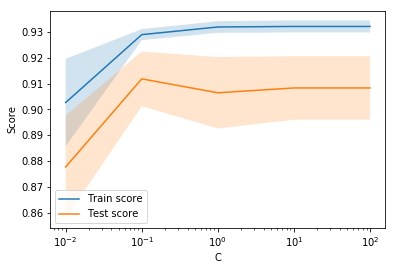

In [52]:
results.plot('param_svc__C', 'mean_train_score', label='Train score')
results.plot('param_svc__C', 'mean_test_score', label='Test score', ax=plt.gca())
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_svc__C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

### 2.3 Precision-recall curve

In [53]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

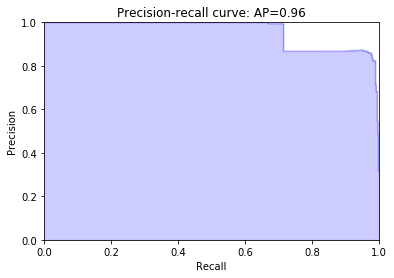

In [54]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

### 2.4 Evaluation of test set

In [55]:
y_true, y_pred = y_test, clf.predict(X_test)

In [56]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97      1759
          1       0.86      0.97      0.91       579

avg / total       0.96      0.95      0.95      2338



In [57]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.929


In [58]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.912


### 2.5 Top predictors of spam

Clearly there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to in these specific emails. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set, or we can adjust `CountVectorizer` in the pipeline (or do a grid search over some additional hyperparameters).

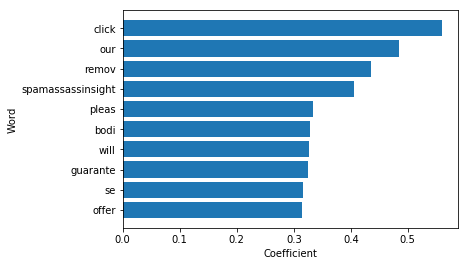

In [59]:
def plot_top(coef, names, n=10):
    coef_argsorted = np.argsort(coef)
    feature_names_array = np.array(names)
    words = []
    values = []
    for i in range(-n,0):
        words.append(names[coef_argsorted[i]])
        values.append(coef[coef_argsorted[i]])

    y = np.arange(n)
    plt.barh(y, values)
    plt.yticks(y, words)
    plt.xlabel('Coefficient')
    plt.ylabel('Word')
    plt.show()
    
plot_top(clf.best_estimator_.named_steps['svc'].coef_.toarray()[0], 
         clf.best_estimator_.named_steps['vect'].get_feature_names())